### Melting rate 2D Stefan One-Phase

In [1]:
import sys; sys.path.insert(1, '..'); from stefanLib import *
_n,_t  = np.newaxis,tf.newaxis # Shortcuts
# Problem parameters
data                  = pd.read_csv("Data/Parameters, Hadzic 2D1P.csv",index_col = 0)
display(data)
probParams            = data[["d","T","R","r","L","eta","gamma"]].loc["value"].to_dict()
probParams["d"]       = int(probParams["d"])
probParams["alpha"]   = {i: data["alpha%d"%i].loc["value"] for i in [1,2]}
probParams["c"]       = {i: data["c%d"%i].loc["value"] for i in [1,2]}
probParams.update({"phase": int(data["phase"]), "tension": int(data["tension"])})

d,T,R,r,L,eta,gam,alpha,c,phase,tension = probParams.values()

# Initial Level-set function
Phi0    = lambda x: tf.cast(tf.norm(x,axis = 2,ord = 2) - r,dtype = tf.float32)
# Volume of domain and initial ice region
vOmega = vBall[d]*R**d; vGamma0 = vBall[d]*r**d 
# Update problem parameters
probParams.update({"Phi0": Phi0,"vOmega": vOmega, "vGamma0": vGamma0})  
# Training parameters (default)
trnParams = trainParams(probParams); trnParams["C"] = vOmega/2

,d,T,R,r,L,alpha1,alpha2,eta,gamma,c1,c2,phase,tension
value,2,0.5,1.0,0.5,0.25,0.5,0.5,1.0,0.0,1.0,1.0,1,0


Overwritable parameters:
d  T  R  r  L  eta  gamma  alpha  c  phase  tension  Phi0  vOmega  vGamma0  B  M  K  dt  N  ts  eps  delta  bdrySim  lbda0  C  Problem parameters


,0
d,2
T,0.5
R,1
r,0.5
L,0.25
eta,1
gamma,0
alpha,"{1: 0.5, 2: 0.5}"
c,"{1: 1.0, 2: 1.0}"
phase,1


Training parameters


,0
B,1024
M,1000
K,200
dt,0.01
N,50
ts,"[[0.0], [0.01], [0.02], [0.03], [0.04], [0.05]..."
eps,"{1: 0.1, 2: 0.1, 0: 0.1}"
delta,"{1: 0.2, 2: 0.2}"
bdrySim,1000
lbda0,0.1


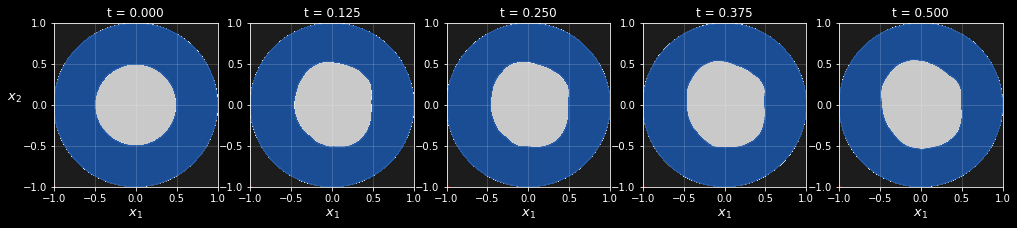

In [ ]:
# Overwrite default parameters (add key and value in newParams dictionary):
print("Overwritable parameters:")
for k in list(probParams.keys())+list(trnParams.keys()): print(k,end = "  ")
# New parameters dictionary
newParams = {"B": 2**10, "M": 1000,"K": 100*d}
#=======================================================#
# Training
NN = newNN(d) # Comment this line to train longer
NN,losses,pens,lbdas = train(NN,probParams,newParams,show = True)

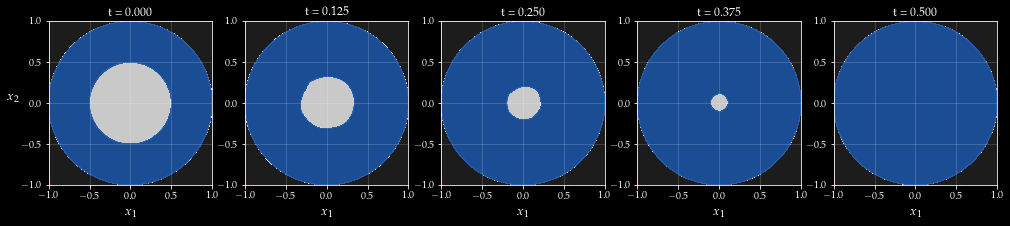

In [11]:
figName = "Figures/2D Hadzic, T = %2.1f, L = %2.2f, alpha1 = %2.2f, alpha2 = %2.2f, R = %d"%(T,L,alpha[1],alpha[2],R)

viz(NN,probParams,trnParams,sharp = False,save = 0,figName = figName)

# Compare to asymptotic melting rate:
$$\lambda(t) \approx \sqrt{T^*-t}\, e^{-\frac{1}{\sqrt{2}} \sqrt{|\log (T^*-t)|}}, \quad t \to T^* = \text{melting time.} $$


In [ ]:
B,M,K,dt,N,ts,eps,delta,bdrySim,lbda0,C = trnParams.values()

Lambda = lambda t: np.sqrt(np.maximum(TStar - t,0.)) * np.exp(- np.sqrt(np.abs(np.log(np.maximum(TStar - t,1e-10)))/2))
nR = 1000; nA = 200
cols = ["mediumorchid","coral","darkred","crimson","darkorchid"]#slateblue
rGrid = np.linspace(0,R,nR)[:,_n,_n]
tol = 1e-2 # Tolerance to find radius
# Plot
Lbdat  = np.zeros_like(ts)
angles = simBall(nA,1.,1.,d)
rt     = np.zeros((N+1,nA))
for i in range(nA):
    X   = rGrid @ angles[i]
    X   = np.reshape(np.tile(X,(1,1,N+1)),(nR,N+1,d))
    G   = nnOut(NN,ts,X,R,T).numpy(); phi = Phi0(X)  + G 
    rt[:,i] = np.array([rGrid[np.argmin(np.abs(phi[:,n]))][0,0] for n in range(N+1)])
Lbdat = np.mean(rt,axis = 1); stdt = np.std(rt,axis = 1)
if len(np.where(Lbdat <= tol)[0]) > 0: 
    idStar = np.where(rt <= tol)[0][0] 
    TStar  = ts[idStar]+1e-10
    print("Melting Time: %2.2f"%TStar)
else:
    idStar = N; TStar = T

figName = "Figures/1P2D, Radius, T = %2.1f, L = %2.2f, alpha1 = %2.1f, alpha2 = %2.1f, R = %d.pdf"%(T,L,alpha[1],alpha[1],R)
# PLOT
Lbdat[idStar:],stdt[idStar:] = 0,0
fig, ax    = plt.subplots(1,1,figsize = (7,5))
ax.plot(ts,Lbdat,'-',lw = 2,color = cols[-1],zorder = 3,label = "Deep-Level \ Set")
ax.plot(ts[idStar-30:idStar+1],Lambda(ts[idStar-30:idStar+1]), dashes=(1.5, 0.75),
        label = "Asymptotic Rate", color = cols[1],lw=2.5,alpha = 1.,zorder = 30)
ax.fill_between(ts.flatten(),Lbdat - stdt,Lbdat + stdt, color=cols[0], alpha = 0.3,zorder=2)
ax.fill_between(ts.flatten(),0.,Lbdat, color='w', alpha=0.9)
ax.fill_between(ts.flatten(),Lbdat,R, color='steelblue', alpha=.8)
plt.annotate("Ice",(0.2,Lbdat[int(N/3)]/2),fontsize = 18,color = "steelblue")
plt.annotate("Water",(0.45,R/3),fontsize = 18,color = "w")
plt.xlabel("t",fontsize = 14); plt.ylabel("r",rotation=0,fontsize = 14,labelpad = 12)
plt.yticks(np.arange(0.,1.01,0.1)); plt.ylim(0.,r*1.2); plt.xticks(np.linspace(0.,T,5));
plt.grid(axis = "y",linestyle='--',color = 'k',alpha = 0.1);  #plt.xlim(0.,0.5)#TStar+T/3)
plt.legend(fontsize = 14); #plt.xlim([0,T*0.75])
plt.savefig(figName,dpi = 600,bbox_inches = "tight"); plt.show()
#showRadius(ts,N,T,d,R,NN,Phi0,save = 1,figName = figName)

figName = "Figures/1P2D Rad, Radius Zoom, T = %2.1f, L = %2.2f, alpha1 = %2.1f, alpha2 = %2.1f, R = %d.pdf"%(T,L,alpha[1],alpha[1],R)

# PLOT
fig, ax = plt.subplots(1,1,figsize = (7,5))
ax.plot(ts,Lbdat,'-',lw = 2.5,color = cols[-1],zorder = 3,label = "Deep-Level \ Set")
#ax.plot(ts,Lbdat - stdt,ts, Lbdat + stdt,lw = 2,color = cols[0],alpha = 0.5)
ax.plot(ts[:idStar+1],Lambda(ts[:idStar+1]),label = "Asymptotic Rate", color = cols[1],dashes=(3, 1),
        lw=2,alpha = 1.,zorder = 30)#, dashes=(3, 0.7)
ax.fill_between(ts.flatten(),Lbdat - stdt,Lbdat + stdt, color=cols[0], alpha = 0.3,zorder=2)
ax.fill_between(ts.flatten(),0.,Lbdat, color='w', alpha=0.9)
ax.fill_between(ts.flatten(),Lbdat,R, color='steelblue', alpha=.8)
plt.annotate("Ice",(0.33,Lbdat[int(N/3)]/2),fontsize = 17,color = "steelblue"); plt.annotate("Water",(0.45,R/8),fontsize = 17,color = "w")
plt.xlabel("t",fontsize = 14); plt.ylabel("r",rotation=0,labelpad = 12,fontsize = 14)
plt.yticks(np.arange(0.,1.01,0.1)); plt.ylim(0.,r/2); plt.xlim(TStar-T/6,TStar+T/8)
plt.grid(axis = "y",linestyle='-',color = 'k',alpha = 0.1)
plt.savefig(figName,dpi = 600,bbox_inches = "tight")
plt.legend(fontsize = 14); plt.show()

In [ ]:
lossesNew = losses0 + losses

def showLosses(losses,burnIn=10,what = "Loss",save = False,figName = None,semilogy = 0):
    """Plot loss vs training iteration."""
    losses = losses[burnIn:] # Remove burn-in period (optional)
    plt.figure(figsize=(6,3))
    if semilogy:
        plt.semilogy(burnIn + np.arange(1,len(losses)+ 1),losses,color ="steelblue")
    else: 
        plt.plot(burnIn + np.arange(1,len(losses)+ 1),losses,color ="steelblue")
    plt.xlabel("Training Step"); plt.title("%s vs Training Step"%what)
    if save: plt.savefig(figName,dpi = 600,bbox_inches = "tight")
    plt.show()

figName = "Figures/Loss vs Time, 1P2D T = %2.1f, L = %2.2f, alpha1 = %2.1f, alpha2 = %2.1f, R = %d.pdf"%(T,L,alpha[1],alpha[1],R)
showLosses(losses,what = "Loss",save = 1, figName = figName,semilogy = 0) #[np.log10(l+1e-12) for l in losses]

figName = "Figures/Penalty vs Time, 1P2D T = %2.1f, L = %2.2f, alpha1 = %2.1f, alpha2 = %2.1f, R = %d.pdf"%(T,L,alpha[1],alpha[1],R)
showLosses(pens,what = "Penalty",save = 1, figName = figName)